In [1]:
!nvidia-smi

Fri Mar 14 03:22:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install git+https://github.com/abbasilab/celltransformer

  Cloning https://github.com/abbasilab/celltransformer to /tmp/pip-req-build-f16ug5dh
  Running command git clone --filter=blob:none --quiet https://github.com/abbasilab/celltransformer /tmp/pip-req-build-f16ug5dh
  Resolved https://github.com/abbasilab/celltransformer to commit 9421d89d465b54dc910b0eff8dbdba4eb06abedf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!curl -L https://huggingface.co/datasets/alxlee/celltransformer_materials/resolve/main/model_weights.pth -o model_weights.pth
!curl -L https://huggingface.co/datasets/alxlee/celltransformer_materials/resolve/main/section_52_metadata.csv -o section_52_metadata.csv
!curl -L https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/expression_matrices/MERFISH-C57BL6J-638850-sections/20240330/C57BL6J-638850.52-log2.h5ad -o C57BL6J-638850.52-log2.h5ad

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1118  100  1118    0     0   4121      0 --:--:-- --:--:-- --:--:--  4125
100 72.7M  100 72.7M    0     0  73.9M      0 --:--:-- --:--:-- --:--:--  128M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1193  100  1193    0     0   5972      0 --:--:-- --:--:-- --:--:--  5994
100 37.4M  100 37.4M    0     0  53.9M      0 --:--:-- --:--:-- --:--:--  118M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187M  100  187M    0     0  30.2M      0  0:00:06  0:00:06 --:--:-- 33.6M


In [4]:
import torch
import tqdm
import anndata as ad
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import celltransformer
from cuml import KMeans

In [5]:
metadata = pd.read_csv('section_52_metadata.csv') # this is just the section 52 metadata pulled from
                                                  # the S3 for ABC @ https://allen-brain-cell-atlas.s3.us-west-2.amazonaws.com/index.html#metadata/
adata = ad.read_h5ad('C57BL6J-638850.52-log2.h5ad')

In [6]:
metadata['cell_label'] = metadata['cell_label'].astype(str)
metadata = metadata[metadata['cell_label'].isin(adata.obs.index)]
metadata['x'] = metadata['x_reconstructed'] * 100 # xfm to microns
metadata['y'] = metadata['y_reconstructed'] * 100

le = LabelEncoder()
# we'll use subclass level cell types as in the paper
le.fit(sorted(metadata['subclass'].unique()))
metadata['cell_type'] = le.transform(metadata['subclass'])

# we only need these columns from now on
metadata = metadata[['cell_label', 'x', 'y', 'cell_type', 'brain_section_label']]

In [7]:
# filter blanks from adata, as well as cells not present in metadata
adata_filt = adata[metadata['cell_label'], ~adata.var.index.str.contains('Blank')] # filter for cells that have a spatial location; filter out Blank genes

In [8]:
sampler = celltransformer.data.CenterMaskSampler(metadata=metadata,
                                                 adata=adata_filt,
                                                 patch_size=(17, 17),
                                                 # as a side note you can use whatever patch size you want; to some extent the model seems robust to these changes once trained
                                                 cell_id_colname='cell_label',
                                                 cell_type_colname='cell_type',
                                                 tissue_section_colname='brain_section_label',
                                                 max_num_cells=None) # if you want to reduce memory usage you might find some mileage by limiting the number of cells

In [9]:
loader = torch.utils.data.DataLoader(sampler,
                                     batch_size=32, # you can use a much higher batch size, but just as an example
                                     shuffle=False, # do not shuffle or the embeddings will be out of order
                                     num_workers=1,
                                     collate_fn=celltransformer.data.collate)

In [10]:
model = celltransformer.model.CellTransformer(encoder_depth=4,
                              encoder_embedding_dim=384,
                              decoder_embedding_dim=384,
                              decoder_depth=4,
                              encoder_num_heads=8,
                              decoder_num_heads=8,
                              n_genes=500,
                              cell_cardinality=384,
                              bias=True
                              )

weights = torch.load('model_weights.pth')
model.load_state_dict(weights)
model = model.cuda()

<ipython-input-10-72726e1018af>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('model_weights.pth')


In [11]:
bf16_context = torch.amp.autocast('cuda', dtype=torch.bfloat16)
import tqdm
embeds = []
with torch.inference_mode(), bf16_context:
    for batch in tqdm.tqdm(loader):
        fwd = model(batch)
        embed = fwd['neighborhood_repr'].detach().cpu().numpy()
        embeds.append(embed)

100%|██████████| 2913/2913 [09:21<00:00,  5.19it/s]


In [12]:
embeds_cat = np.concatenate(embeds)

In [13]:
clusterer = KMeans(n_clusters=10)
clusterer.fit(embeds_cat)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


KMeans()

In [14]:
labels = clusterer.predict(embeds_cat)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:193: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  ret = func(*args, **kwargs)


In [15]:
colormap = sns.color_palette(cc.glasbey, n_colors=10)
hex_values = {k: v for k, v in zip(range(len(colormap)), colormap.as_hex())}

metadata['label'] = labels
metadata['cluster_color'] = [hex_values[lbl] for lbl in labels]

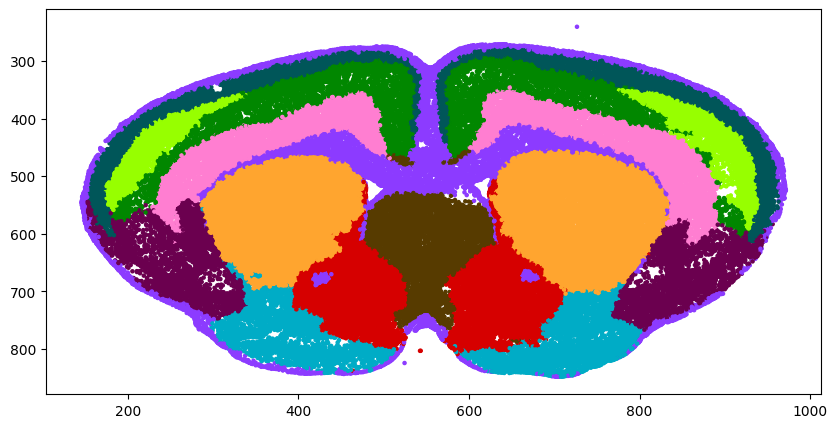

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 5))
g = plt.scatter(x=metadata['x'], y=metadata['y'], c=metadata['cluster_color'], s=5)
plt.gca().invert_yaxis()